# Earthquakes 1990-2023 EDA and Predictions
https://www.kaggle.com/datasets/alessandrolobello/the-ultimate-earthquake-dataset-from-1990-2023

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.graphics import tsaplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import pickle

%matplotlib inline

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Dataset

In [ ]:
earthquake_df = pd.read_csv("drive/MyDrive/Eartquakes-1990-2023.csv")
earthquake_df.head()

,time,place,status,tsunami,significance,data_type,magnitudo,state,longitude,latitude,depth,date
0,631153353990,"12 km NNW of Meadow Lakes, Alaska",reviewed,0,96,earthquake,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,"14 km S of Volcano, Hawaii",reviewed,0,31,earthquake,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,"7 km W of Cobb, California",reviewed,0,19,earthquake,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,"11 km E of Mammoth Lakes, California",reviewed,0,15,earthquake,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,"16km N of Fillmore, CA",reviewed,0,134,earthquake,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


In [ ]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3445751 entries, 0 to 3445750
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time          int64  
 1   place         object 
 2   status        object 
 3   tsunami       int64  
 4   significance  int64  
 5   data_type     object 
 6   magnitudo     float64
 7   state         object 
 8   longitude     float64
 9   latitude      float64
 10  depth         float64
 11  date          object 
dtypes: float64(4), int64(3), object(5)
memory usage: 315.5+ MB


# **Preprocessing:**

**Filtering only earthquake data_type**

In [ ]:
earthquake_df = earthquake_df.loc[earthquake_df['data_type'] == 'earthquake']

**Dropping columns: place, status, tsunami, data_type**

In [ ]:
earthquake_df = earthquake_df.drop(['place', 'status', 'tsunami', 'data_type'], axis=1)

**Percentage of Missing Values**

In [ ]:
round(earthquake_df.isna().sum() / earthquake_df.shape[0], 2) * 100

time            0.0
significance    0.0
magnitudo       0.0
state           0.0
longitude       0.0
latitude        0.0
depth           0.0
date            0.0
dtype: float64

**handling Duplicates**

In [ ]:
# Finding duplicate rows
duplicate_rows_count = earthquake_df[earthquake_df.duplicated(keep='first')].shape[0]

# Displaying the duplicate rows
print(f"Number of duplicate rows: {duplicate_rows_count}")

# Drop duplicates rows
earthquake_df.drop_duplicates(keep='first', inplace=True)

Number of duplicate rows: 16487


**Magnitude and Significance are highly corelated, therefore we can drop significance**

In [ ]:
earthquake_df = earthquake_df.drop(['significance'], axis=1)
earthquake_df.head()

,time,magnitudo,state,longitude,latitude,depth,date
0,631153353990,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


In [ ]:
earthquake_df['state'].unique()

It seems the state column has countries, regions, and states of america.
We should rename this column to something more appropriate for the data it holds.

**Also, renaming magnitudo to magnitude.**

In [ ]:
earthquake_df = earthquake_df.rename(columns={"state": "region", "magnitudo": "magnitude"})
earthquake_df.head(5)

,time,magnitude,region,longitude,latitude,depth,date
0,631153353990,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


**Making date as a datetime type and removing time part.**

In [ ]:
earthquake_df['date'] = pd.to_datetime(earthquake_df.date, format='%Y/%m/%d')
earthquake_df['date'] = earthquake_df['date'].dt.date
earthquake_df['date'] = pd.to_datetime(earthquake_df.date, format='%Y/%m/%d')
earthquake_df.head()

,time,magnitude,region,longitude,latitude,depth,date
0,631153353990,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01
1,631153491210,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01
2,631154083450,1.11,California,-122.806167,38.821000,3.220,1990-01-01
3,631155512130,0.98,California,-118.846333,37.664333,-0.584,1990-01-01
4,631155824490,2.95,California,-118.934000,34.546000,16.122,1990-01-01


**Transforming numerical features based on Domain knowledge**

In [ ]:
# Transforming depth number to depth levels
def depth_levels(row):
   if row['depth'] <= 70:
      return 1
   elif row['depth'] <= 300:
      return 2
   else:
      return 3

# Transforming integers to base of 5
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

earthquake_df['depth'] = earthquake_df.apply(depth_levels, axis=1)

# Rounding off decimals and then the integer to a base of 5
features = ['latitude', 'longitude']

for feature in features:
  earthquake_df[feature] = earthquake_df[feature].astype(int)
  earthquake_df[feature] = pd.Series(earthquake_df[feature]).apply(lambda x: custom_round(x, base=5))

# Eliminating least significant mangitude records
earthquake_df = earthquake_df[earthquake_df['magnitude'] > -2.5]

# Tranforming magnitude into categories as per severity of impact
def earthquake_category(magnitude):
    if magnitude < 3:
        return 1
    elif 3 >= magnitude < 4:
        return 2
    elif 4 >= magnitude < 5:
        return 3
    elif 5 >= magnitude < 6:
        return 4
    elif 7 >= magnitude < 8:
        return 5
    else:
        return 6

earthquake_df['class'] = earthquake_df['magnitude'].apply(earthquake_category)

**Proprocessing region column to remove leading spaces.**

In [ ]:
earthquake_df['region'] = earthquake_df['region'].str.strip()

**TODO: Detecting Outliers**

# Machine Learning Models

1.   K-means
2.   Time Searies Analysis
3.   Multi-class Classification



# Time series analysis

In [ ]:
df=earthquake_df.copy()

ts = pd.Series(df.magnitude.values, index=df.date, name='magnitude')
ts.index = pd.DatetimeIndex(ts.index, freq=ts.index.inferred_freq)
ai_df = tsatools.add_trend(ts, trend='ct')
ai_df['Month']=ai_df.index.month

In [ ]:
valid=int(0.3*len(ts))
train=len(ts)-valid
train_df=ai_df[:train]
valid_df=ai_df[train:]

lm_poly_mon_trend=sm.ols(formula='magnitude ~ trend + C(Month)', data=train_df).fit()
pred_poly_mon_trend=lm_poly_mon_trend.predict(valid_df)
print(lm_poly_mon_trend.summary())
rmse=np.sqrt(mean_squared_error(valid_df['magnitude'], pred_poly_mon_trend))
print('RMSE for Model with month and trend')
print(rmse)

                            OLS Regression Results                            
Dep. Variable:              magnitude   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2428.
Date:                Thu, 22 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:03:00   Log-Likelihood:            -3.9415e+06
No. Observations:             2341300   AIC:                         7.883e+06
Df Residuals:                 2341287   BIC:                         7.883e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1069      0.003    637.

Plot Graph

In [ ]:
train_ts = ts[:train]
valid_ts = ts[train:]

train_ts=pd.Series(train_ts.values, index=train_ts.index.to_period('D'))
valid_ts=pd.Series(valid_ts.values, index=valid_ts.index.to_period('D'))

# moving average on training
#ma_trailing = train_ts.groupby(train_ts.index).mean()
ma_trailing = ts.rolling(365).mean()
last_ma = ma_trailing[-1]

#print(ma_trailing)
#print(last_ma)
#print(train_ts)

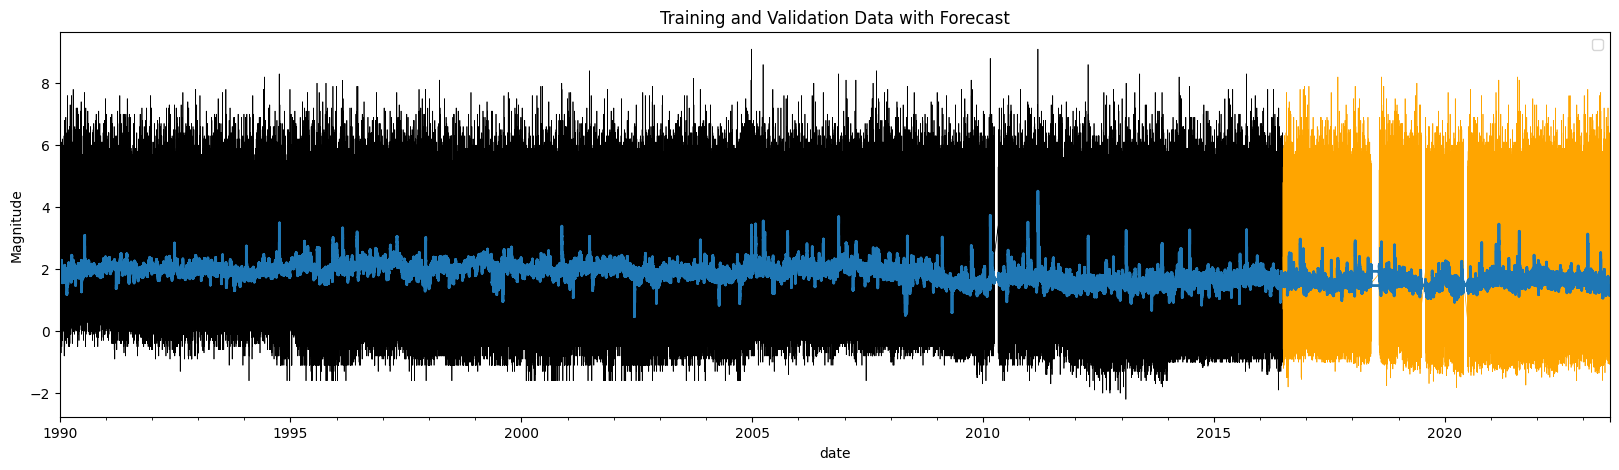

In [ ]:
# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index=valid_ts.index)

fig, ax = plt.subplots(figsize=(20,5))

# Set x-axis limit
ax.set_xlim([-10, 10])
#ax.set_xlim([1990, 2023])
# Add legend, labels, and title
ax.legend(['Train', 'Validation', 'Moving Average', 'Forecast'])
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Training and Validation Data with Forecast')

train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='orange', linewidth=0.5)
ma_trailing.plot(ax=ax, linewidth=2, color='C0')
ma_trailing_pred.plot(ax=ax, style='--', linewidth=2, color='C0')

plt.show()

Build a model with seasonality, trend, and quadratic trend to get Prediction

In [ ]:
df = tsatools.add_trend(ts, trend='ct')
df['Month'] = df.index.month

# partition the data
train_df = df[:train]
valid_df = df[train:]

formula = 'magnitude ~ trend + C(Month)'
lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

# create single-point forecast
prediction = lm_trendseason.predict(valid_df.iloc[0, :])

# apply MA to residuals
ma_trailing = lm_trendseason.resid.rolling(12).mean()

print('Prediction', prediction[0])
print('ma_trailing', ma_trailing[-1])

Prediction 1.5889117048258643
ma_trailing 0.13775357709566402
